# Prompt Chaining: Amazon Bedrock 시작하기

이 노트북은 Amazonb Bedrock 의 LLM 을 사용하는 방법을 
가이드하는 노트북 입니다.

구체적으로 LangGraph 로 Prompt Chaining 하는 방법을 배웁니다.

### 참조
- [LangGraph: Workflows and Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#prompt-chaining)
- What is chat messages, chat model, binding tools? --> [Build a simple graph with nodes, normal edges, and conditional edges.](https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb)




---

## 1. 선수 사항: 
### 1.1  콘다 가상 환경 생성
- 아래의 설치 가이드에 따라 먼저 진행 해주세요.
    - [환경 설치 가이드: ](https://github.com/aws-samples/aws-ai-ml-workshop-kr/tree/master/genai/aws-gen-ai-kr/20_applications/19_agentic_rag)


## 2. 환경 설정

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)


module_path = ".."
add_python_path(module_path)

from utils.langgraph_util import ( 
    show_graph_dag,
)

python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/05_start_agentic_workflow_langgraph_bedrock_langfuse is added
sys.path:  ['/home/sagemaker-user/.conda/envs/agent-workflow/lib/python310.zip', '/home/sagemaker-user/.conda/envs/agent-workflow/lib/python3.10', '/home/sagemaker-user/.conda/envs/agent-workflow/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.conda/envs/agent-workflow/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/05_start_agentic_workflow_langgraph_bedrock_langfuse']


## 4. LangChain 인터페이스의 Bedrock 모델 생성
- LangChain 개발자 가이드: [ChatBedrock](https://python.langchain.com/docs/integrations/chat/bedrock/)

]

In [2]:
from langchain_aws import ChatBedrockConverse

# model_id = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
model_id = "us.amazon.nova-pro-v1:0"

llm = ChatBedrockConverse(
    model= model_id,
    temperature=0,
    max_tokens=None,
    # other params...
)

llm

ChatBedrockConverse(client=<botocore.client.BedrockRuntime object at 0x7f6068237250>, model_id='us.amazon.nova-pro-v1:0', temperature=0.0, region_name='us-east-1', provider='amazon', supports_tool_choice_values=['auto'])

## 5. Grpah 정의 하기

### State 정의

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

### Node 및 분기  함수 정의

In [4]:
# Node: 첫번째 농담 생성 
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']} in Korean")
    return {"joke": msg.content}

In [5]:
# 분기문: 농담의 결정적 부분이 있는지 확인. ! , ? 의 유무로 판단
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

In [6]:
# Node: 특정 단어를 제공하여, 조금 더 농담을 재미있게 생성
def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay in Korean: {state['joke']}")
    return {"improved_joke": msg.content}

In [7]:
# Node: 제공 받은 농담을 한번더 "놀라운 반전" 을 생성 합니다.
def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']} in Korean")
    return {"final_joke": msg.content}

### 그래프 구조 만들기

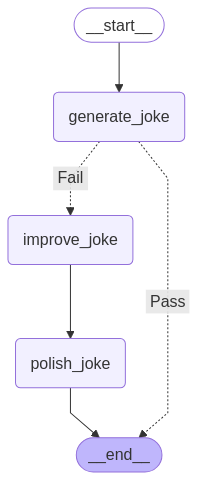

In [8]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

### Graph 호출

In [9]:
# Invoke
state = chain.invoke({"topic": "고양이"},
)

### 최종 State 값 보기
- 각 Node 에서 State Class 의 변수에 값을 할당함.

In [10]:
state

{'topic': '고양이',
 'joke': '물론입니다! 여기 고양이에 관한 짧은 농담이 있습니다:\n\n---\n\n고양이가 컴퓨터 앞에 앉아 있더니 갑자기 큰 소리로 "냐옹!" 하고 쳤습니다. \n\n왜냐하면 고양이는 세상에서 가장 작은 유머리스트이기 때문입니다. 😆\n\n---\n\n웃음이 되셨길 바랍니다!',
 'improved_joke': '물론입니다! 여기 고양이에 관한 짧은 농담에 한국어 언어 유희를 추가한 버전이 있습니다:\n\n---\n\n고양이가 컴퓨터 앞에 앉아 있더니 갑자기 큰 소리로 "냐옹!" 하고 쳤습니다. \n\n왜냐하면 고양이는 세상에서 가장 작은 유머리스트이기 때문입니다. 😆\n\n그리고 그 고양이는 자기가 완전 "키보드 캣(Keyboard Cat)"이라고 생각합니다. 왜냐하면 키보드를 누를 때마다 "냐옹냐옹, 재미있잖아!" 하는 거죠. 그래서 고양이는 항상 "마우스도 잘 잡아!" 라고 스스로에게 격려합니다. 왜냐하면 고양이는 진짜 "유머스 타이핑(Humorous Typing)"의 달인이기 때문이죠! 🤣\n\n웃음이 되셨길 바랍니다!',
 'final_joke': '물론입니다! 여기 고양이에 관한 짧은 농담에 한국어 언어 유희와 놀라운 반전을 추가한 버전이 있습니다:\n\n---\n\n고양이가 컴퓨터 앞에 앉아 있더니 갑자기 큰 소리로 "냐옹!" 하고 쳤습니다. \n\n왜냐하면 고양이는 세상에서 가장 작은 유머리스트이기 때문입니다. 😆\n\n그리고 그 고양이는 자기가 완전 "키보드 캣(Keyboard Cat)"이라고 생각합니다. 왜냐하면 키보드를 누를 때마다 "냐옹냐옹, 재미있잖아!" 하는 거죠. 그래서 고양이는 항상 "마우스도 잘 잡아!" 라고 스스로에게 격려합니다. 왜냐하면 고양이는 진짜 "유머스 타이핑(Humorous Typing)"의 달인이기 때문이죠! 🤣\n\n그런데 놀랍게도, 고양이가 컴퓨터를 계속 치다가 갑자기 화면에 나타난 것은 다름 아닌 자기 주인의 얼굴이었습니다. 주인은 고양이가 컴퓨터를 친다는 소식을 듣고 

### State 값 흐름에 따라 출력

In [11]:

print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
물론입니다! 여기 고양이에 관한 짧은 농담이 있습니다:

---

고양이가 컴퓨터 앞에 앉아 있더니 갑자기 큰 소리로 "냐옹!" 하고 쳤습니다. 

왜냐하면 고양이는 세상에서 가장 작은 유머리스트이기 때문입니다. 😆

---

웃음이 되셨길 바랍니다!

--- --- ---

Improved joke:
물론입니다! 여기 고양이에 관한 짧은 농담에 한국어 언어 유희를 추가한 버전이 있습니다:

---

고양이가 컴퓨터 앞에 앉아 있더니 갑자기 큰 소리로 "냐옹!" 하고 쳤습니다. 

왜냐하면 고양이는 세상에서 가장 작은 유머리스트이기 때문입니다. 😆

그리고 그 고양이는 자기가 완전 "키보드 캣(Keyboard Cat)"이라고 생각합니다. 왜냐하면 키보드를 누를 때마다 "냐옹냐옹, 재미있잖아!" 하는 거죠. 그래서 고양이는 항상 "마우스도 잘 잡아!" 라고 스스로에게 격려합니다. 왜냐하면 고양이는 진짜 "유머스 타이핑(Humorous Typing)"의 달인이기 때문이죠! 🤣

웃음이 되셨길 바랍니다!

--- --- ---

Final joke:
물론입니다! 여기 고양이에 관한 짧은 농담에 한국어 언어 유희와 놀라운 반전을 추가한 버전이 있습니다:

---

고양이가 컴퓨터 앞에 앉아 있더니 갑자기 큰 소리로 "냐옹!" 하고 쳤습니다. 

왜냐하면 고양이는 세상에서 가장 작은 유머리스트이기 때문입니다. 😆

그리고 그 고양이는 자기가 완전 "키보드 캣(Keyboard Cat)"이라고 생각합니다. 왜냐하면 키보드를 누를 때마다 "냐옹냐옹, 재미있잖아!" 하는 거죠. 그래서 고양이는 항상 "마우스도 잘 잡아!" 라고 스스로에게 격려합니다. 왜냐하면 고양이는 진짜 "유머스 타이핑(Humorous Typing)"의 달인이기 때문이죠! 🤣

그런데 놀랍게도, 고양이가 컴퓨터를 계속 치다가 갑자기 화면에 나타난 것은 다름 아닌 자기 주인의 얼굴이었습니다. 주인은 고양이가 컴퓨터를 친다는 소식을 듣고 놀라서 뛰어왔던 것입니다. 그리고 고양이는 주인의